# Berlin Weather Data Visualization 2024

This notebook visualizes Berlin weather data from 2024 and maps WMO weather codes to their descriptions.

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import calendar

# Set visualization style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

## Load and Prepare Data

In [5]:
# Load the Berlin weather data
weather_data_path = 'datasets/berlin_weather_2024.csv'
df = pd.read_csv(weather_data_path, sep=';')

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,weather_code (wmo code),temperature_2m_mean (°C),sunshine_duration (s),rain_sum (mm),snowfall_sum (cm)
0,2024-01-01,53,5.2,17859.23,1.9,0.00
1,2024-01-02,73,4.7,0.00,9.8,0.28
2,2024-01-03,63,8.7,3789.20,9.3,0.00
3,2024-01-04,51,3.4,0.00,2.6,0.00
4,2024-01-05,73,0.4,0.00,1.4,2.80


## Load WMO Weather Codes

In [6]:
# Load the WMO weather codes
wmo_codes_path = 'datasets/wmo_weather_code.json'

with open(wmo_codes_path, 'r') as f:
    wmo_codes = json.load(f)

# Create a mapping dictionary for day descriptions
wmo_descriptions = {int(code): data['day']['description'] for code, data in wmo_codes.items()}

# Display a few examples of the mapping
print('Example WMO code mappings:')
for code in sorted(list(wmo_descriptions.keys())[:10]):
    print(f'Code {code}: {wmo_descriptions[code]}')

Example WMO code mappings:
Code 0: Sunny
Code 1: Mainly Sunny
Code 2: Partly Cloudy
Code 3: Cloudy
Code 45: Foggy
Code 48: Rime Fog
Code 51: Light Drizzle
Code 53: Drizzle
Code 55: Heavy Drizzle
Code 56: Light Freezing Drizzle


## Map WMO Codes to Descriptions

In [7]:
# Map the weather codes to descriptions
df['weather_code'] = df['weather_code (wmo code)'].astype(int)
df['weather_description'] = df['weather_code'].map(wmo_descriptions)

# Extract month and season for later analysis
df['month'] = df['Date'].dt.month
df['month_name'] = df['Date'].dt.month_name()

# Convert date to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Feature engineering: Extract more date features
df['day_of_week'] = df['Date'].dt.dayofweek
df['day_of_month'] = df['Date'].dt.day


# Display the updated dataframe
display(df[['Date', 'weather_code', 'weather_description', 'temperature_2m_mean (°C)', 'month_name']].head(10))

,Date,weather_code,weather_description,temperature_2m_mean (°C),month_name
0,2024-01-01,53,Drizzle,5.2,January
1,2024-01-02,73,Snow,4.7,January
2,2024-01-03,63,Rain,8.7,January
3,2024-01-04,51,Light Drizzle,3.4,January
4,2024-01-05,73,Snow,0.4,January
5,2024-01-06,71,Light Snow,-0.6,January
6,2024-01-07,73,Snow,-3.2,January
7,2024-01-08,3,Cloudy,-7.0,January
8,2024-01-09,0,Sunny,-7.9,January
9,2024-01-10,1,Mainly Sunny,-6.6,January


In [8]:
import numpy as np
import pandas as pd

# Adding columns with random data
np.random.seed(42)  # for reproducibility

# Basic random sales between 0 and 150
df['burger_sales'] = np.random.randint(0, 151, size=len(df))
df['salad_sales'] = np.random.randint(0, 151, size=len(df))
df['pizza_sales'] = np.random.randint(0, 151, size=len(df))

# Ice cream sales with strong seasonal and weather-based bias
# 1. Create seasonal bias (winter months have very low sales)
winter_months = [12, 1, 2]
spring_months = [3, 4, 5]
summer_months = [6, 7, 8]
fall_months = [9, 10, 11]

# Create a seasonal multiplier (0.1 for winter, 0.6 for spring/fall, 1.0 for summer)
seasonal_factor = np.ones(len(df))
for i, month in enumerate(df['month']):
    if month in winter_months:
        seasonal_factor[i] = 0.1  # Very low in winter
    elif month in spring_months:
        seasonal_factor[i] = 0.6  # Medium in spring
    elif month in summer_months:
        seasonal_factor[i] = 1.0  # High in summer
    elif month in fall_months:
        seasonal_factor[i] = 0.5  # Medium-low in fall

# 2. Create temperature factor (normalized to 0-1.5 range to create stronger effect)
# Scale from 0-1.5 where higher temps give values closer to 1.5
temp_min = df['temperature_2m_mean (°C)'].min()
temp_max = df['temperature_2m_mean (°C)'].max()
temp_factor = 1.5 * (df['temperature_2m_mean (°C)'] - temp_min) / (temp_max - temp_min)

# 3. Create sunshine factor (normalized to 0-1 range)
sunshine_factor = df['sunshine_duration (s)'] / df['sunshine_duration (s)'].max()

# 4. Add a rain penalty (less ice cream on rainy days)
rain_penalty = 1 - (df['rain_sum (mm)'] / df['rain_sum (mm)'].max()).clip(0, 0.7)

# 5. Combine all factors with appropriate weights
combined_factor = (
    0.8 * seasonal_factor +  # Season has strong effect (50%)
    0.2 * temp_factor +      # Temperature has medium effect (30%)
    0.6 * sunshine_factor +  # Sunshine has smaller effect (10%)
    0.3 * rain_penalty       # Rain has smaller effect (10%)
)

# 6. Create base ice cream demand and apply the combined factor
base_ice_cream = np.random.randint(20, 80, size=len(df))  # Base demand
df['ice_cream_sales'] = (base_ice_cream * combined_factor).astype(int)

# 7. Add some randomness for real-world variability (±15%)
randomness = np.random.uniform(0.85, 1.15, size=len(df))
df['ice_cream_sales'] = (df['ice_cream_sales'] * randomness).astype(int)

# Ensure values stay within range
df['ice_cream_sales'] = df['ice_cream_sales'].clip(0, 150)

# 8. Final touch: Force near-zero values for very cold days (below 0°C)
cold_days = df['temperature_2m_mean (°C)'] < 0
df.loc[cold_days, 'ice_cream_sales'] = np.random.randint(0, 5, size=sum(cold_days))

# Display a sample of the dataframe with the new columns
df.head(10)

,Date,weather_code (wmo code),temperature_2m_mean (°C),sunshine_duration (s),rain_sum (mm),snowfall_sum (cm),weather_code,weather_description,month,month_name,day_of_week,day_of_month,burger_sales,salad_sales,pizza_sales,ice_cream_sales
0,2024-01-01,53,5.2,17859.23,1.9,0.00,53,Drizzle,1,January,0,1,102,139,150,15
1,2024-01-02,73,4.7,0.00,9.8,0.28,73,Snow,1,January,1,2,92,128,106,25
2,2024-01-03,63,8.7,3789.20,9.3,0.00,63,Rain,1,January,2,3,14,57,17,20
3,2024-01-04,51,3.4,0.00,2.6,0.00,51,Light Drizzle,1,January,3,4,106,121,37,28
4,2024-01-05,73,0.4,0.00,1.4,2.80,73,Snow,1,January,4,5,71,0,114,26
5,2024-01-06,71,-0.6,0.00,0.0,0.98,71,Light Snow,1,January,5,6,20,33,14,4
6,2024-01-07,73,-3.2,5344.28,0.0,0.35,73,Snow,1,January,6,7,102,95,118,0
7,2024-01-08,3,-7.0,23225.03,0.0,0.00,3,Cloudy,1,January,0,8,121,125,27,0
8,2024-01-09,0,-7.9,23340.53,0.0,0.00,0,Sunny,1,January,1,9,74,117,38,0
9,2024-01-10,1,-6.6,23453.27,0.0,0.00,1,Mainly Sunny,1,January,2,10,87,47,16,0


Missing values in each column:
Date                        0
weather_code (wmo code)     0
temperature_2m_mean (°C)    0
sunshine_duration (s)       0
rain_sum (mm)               0
snowfall_sum (cm)           0
weather_code                0
weather_description         0
month                       0
month_name                  0
day_of_week                 0
day_of_month                0
burger_sales                0
salad_sales                 0
pizza_sales                 0
ice_cream_sales             0
dtype: int64

Training Gradient Boosting model for burger_sales...
RMSE for burger_sales: 51.36
R² Score for burger_sales: -0.32


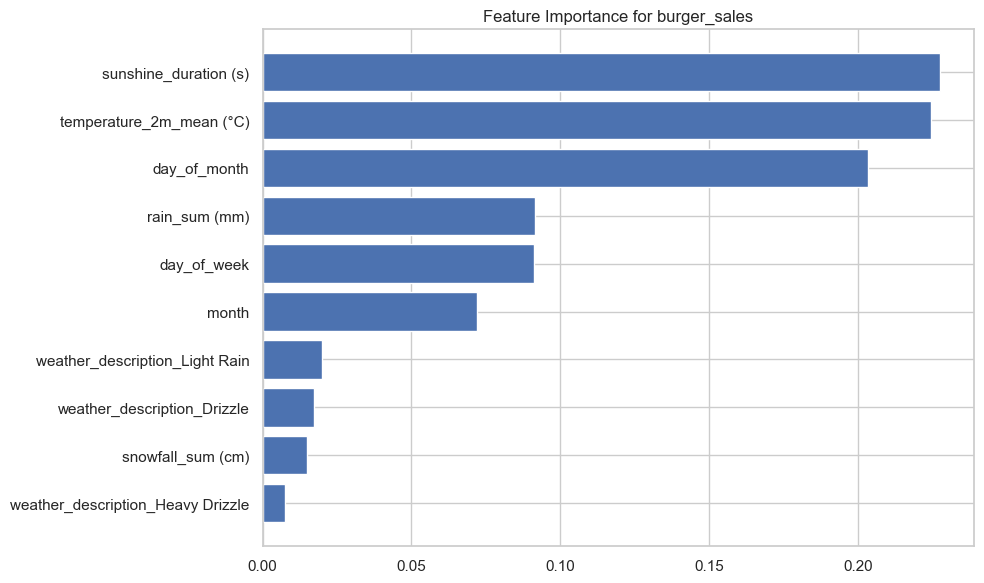


Training Gradient Boosting model for salad_sales...
RMSE for salad_sales: 52.93
R² Score for salad_sales: -0.37


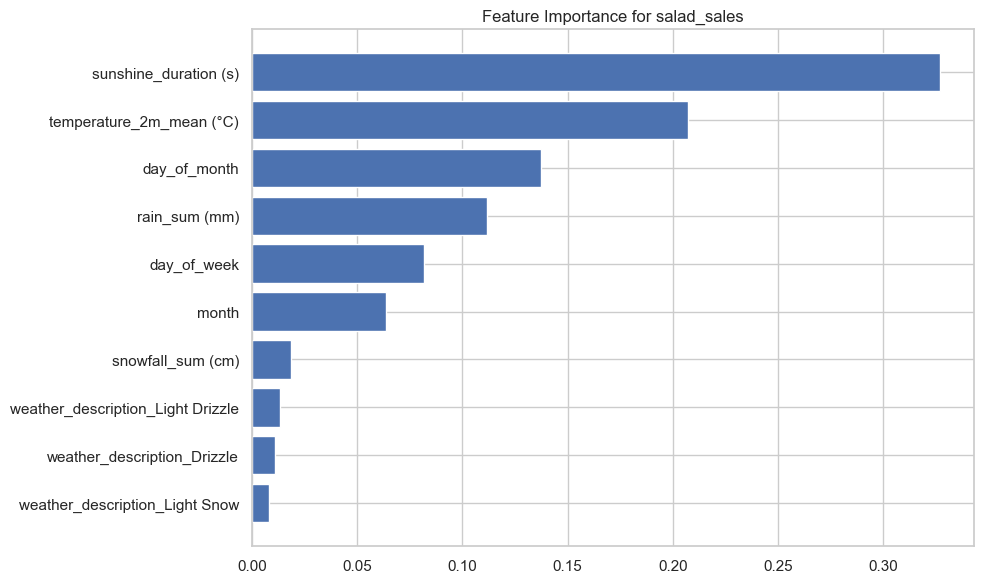


Training Gradient Boosting model for pizza_sales...
RMSE for pizza_sales: 52.96
R² Score for pizza_sales: -0.39


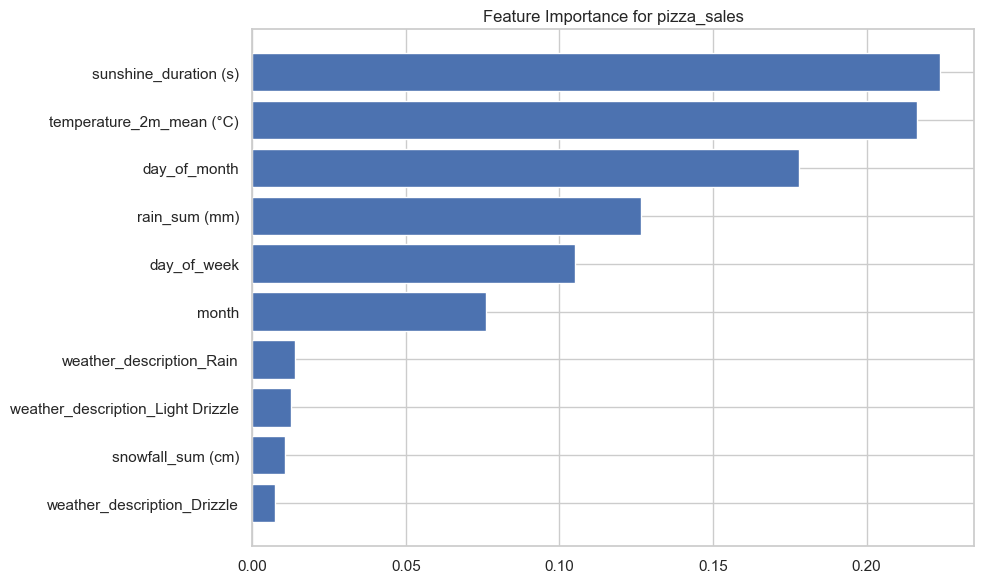


Training Gradient Boosting model for ice_cream_sales...
RMSE for ice_cream_sales: 22.09
R² Score for ice_cream_sales: 0.53


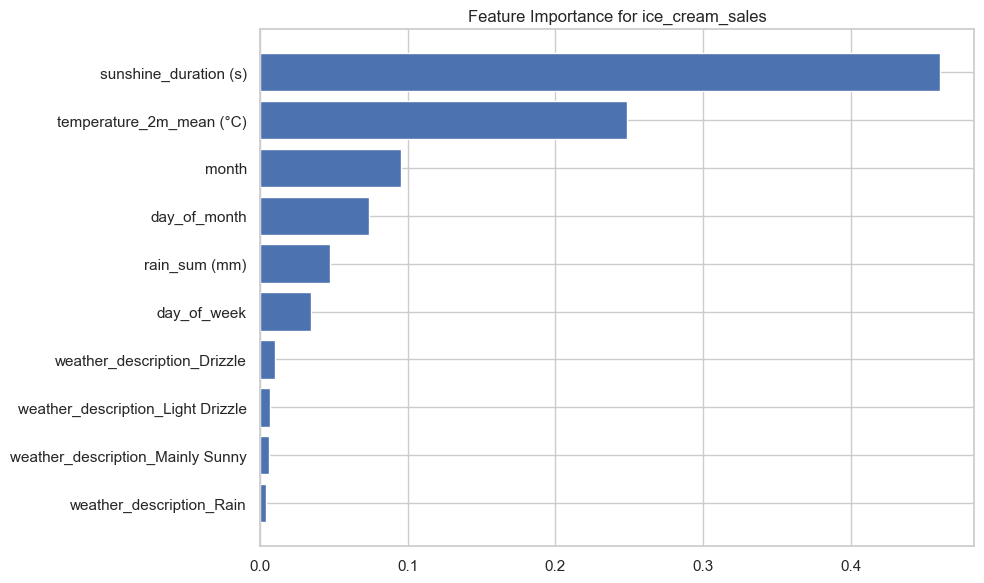

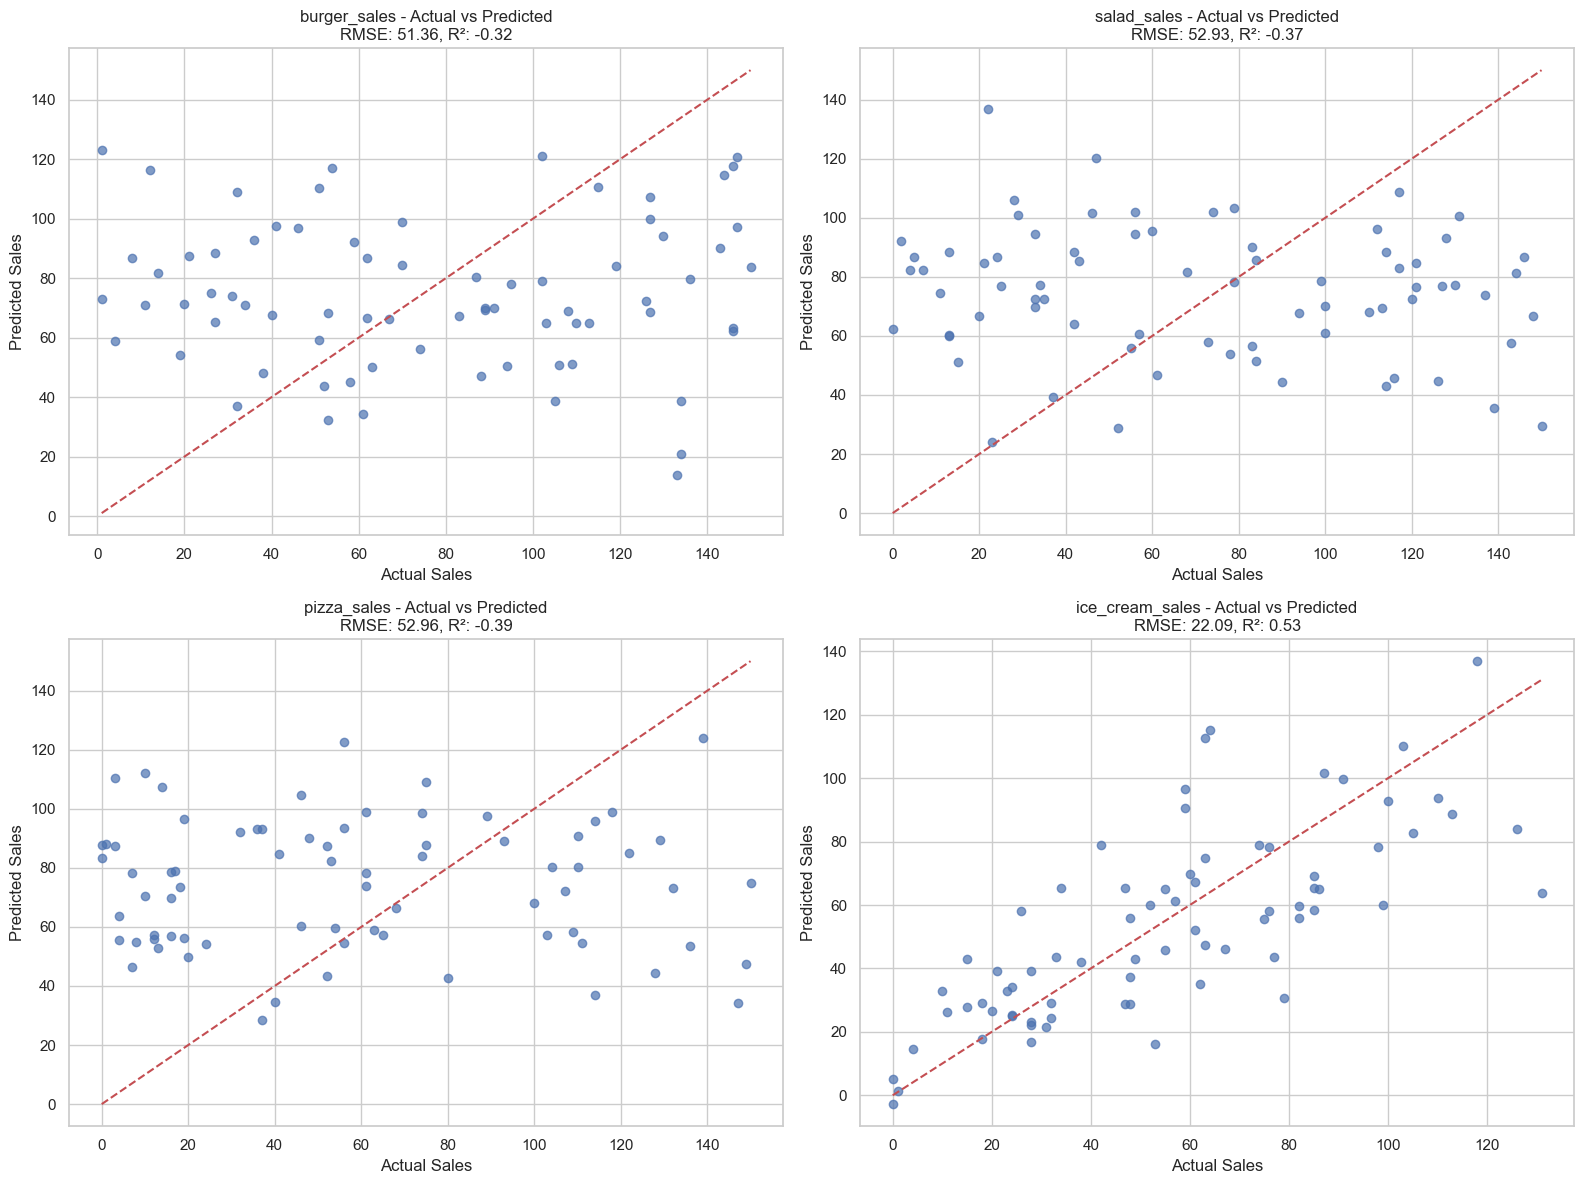

Model for burger_sales saved as burger_sales_gradientboosting_model.pkl
Model for salad_sales saved as salad_sales_gradientboosting_model.pkl
Model for pizza_sales saved as pizza_sales_gradientboosting_model.pkl
Model for ice_cream_sales saved as ice_cream_sales_gradientboosting_model.pkl


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# Assuming your DataFrame is already loaded as 'df'
# If not, uncomment this line and specify your file
# df = pd.read_csv('your_file.csv')

# Check for any missing values
print("Missing values in each column:")
print(df.isna().sum())

# Convert date to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Feature engineering: Extract more date features
df['day_of_week'] = df['Date'].dt.dayofweek
df['day_of_month'] = df['Date'].dt.day

# Define features (X) and targets (y)
# Select weather features and month as input
X_features = ['temperature_2m_mean (°C)', 'sunshine_duration (s)', 'rain_sum (mm)', 
              'snowfall_sum (cm)', 'month', 'day_of_week', 'day_of_month']

# One-hot encode weather description
X_with_dummies = pd.get_dummies(df, columns=['weather_description'], drop_first=True)
X_features.extend([col for col in X_with_dummies.columns if 'weather_description' in col])

X = X_with_dummies[X_features]

# Target variables
food_items = ['burger_sales', 'salad_sales', 'pizza_sales', 'ice_cream_sales']

# Create a common train/test split to ensure consistency
train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

X_train = X.loc[train_idx]
X_test = X.loc[test_idx]

y_train_dict = {}
y_test_dict = {}

for item in food_items:
    y_train_dict[item] = df.loc[train_idx, item]
    y_test_dict[item] = df.loc[test_idx, item]

# Train a Gradient Boosting model for each food item
models = {}
predictions = {}
metrics = {}
feature_importances = {}

for item in food_items:
    print(f"\nTraining Gradient Boosting model for {item}...")
    
    # Initialize GradientBoostingRegressor
    model = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        min_samples_split=2,
        min_samples_leaf=1,
        subsample=0.8,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train_dict[item])
    
    # Store the model
    models[item] = model
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    predictions[item] = y_pred
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_dict[item], y_pred))
    r2 = r2_score(y_test_dict[item], y_pred)
    metrics[item] = {'RMSE': rmse, 'R2': r2}
    
    # Get feature importances
    feature_importances[item] = dict(zip(X_features, model.feature_importances_))
    
    print(f"RMSE for {item}: {rmse:.2f}")
    print(f"R² Score for {item}: {r2:.2f}")
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(model.feature_importances_)[-10:]  # Top 10 features
    plt.barh(range(len(sorted_idx)), model.feature_importances_[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [X_features[i] for i in sorted_idx])
    plt.title(f'Feature Importance for {item}')
    plt.tight_layout()
    plt.show()

# Plot actual vs predicted values for each food item
plt.figure(figsize=(16, 12))
for i, item in enumerate(food_items, 1):
    plt.subplot(2, 2, i)
    plt.scatter(y_test_dict[item], predictions[item], alpha=0.7)
    plt.plot([min(y_test_dict[item]), max(y_test_dict[item])], 
             [min(y_test_dict[item]), max(y_test_dict[item])], 
             'r--')
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')
    plt.title(f'{item} - Actual vs Predicted\nRMSE: {metrics[item]["RMSE"]:.2f}, R²: {metrics[item]["R2"]:.2f}')
    
plt.tight_layout()
plt.show()

# Function to make new predictions
def predict_sales(new_data, models=models):
    """
    Make predictions using trained models
    
    Parameters:
    new_data (DataFrame): New data with the same features as training data
    models (dict): Dictionary of trained models
    
    Returns:
    dict: Dictionary of predictions for each food item
    """
    predictions = {}
    for item, model in models.items():
        predictions[item] = model.predict(new_data)
    return predictions

# Save models for future use
import pickle
for item, model in models.items():
    with open(f'{item}_gradientboosting_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    print(f"Model for {item} saved as {item}_gradientboosting_model.pkl")